In [9]:
import numpy as np
import pandas as pd
import pymysql as ms
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import sklearn.preprocessing as sp
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import RepeatedKFold

import sklearn.linear_model as lm
import sklearn.tree as tree
import sklearn.svm as svm
import sklearn.ensemble as ens
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import sklearn.metrics as met

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import dill
import pickle
import requests
from bs4 import BeautifulSoup
import pymysql

In [10]:
connection = pymysql.connect(
    host='localhost',  # 127.0.0.1
    user='root',
    password='12345678',
    database='ds'
)

In [11]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [12]:
df = pd.read_sql('select * from bina_db', con=connection).set_index('elan_id').drop(['id'], axis=1)

C:\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [13]:
class ColumnDropper():
    def __init__(self, columns):
        self.columns = columns

    def transform(self, _X, y=None):
        X = _X.copy(deep=True)
        return X.drop(self.columns, axis=1)

    def fit(self, X, y=None):
        return self

In [14]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.loc[:, self.feature_names].copy(deep=True)

In [15]:
class AverageCategoricalConverter(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, X, y=None):
        return self

    def transform(self, _X, y=None):
        X = _X.copy(deep=True)
        for feature in self.feature_names:
            feature_avg = X[[feature, 'qiymet']].groupby(by=feature).mean()
            feature_avg.rename(columns={'qiymet': f'{feature}_avg'}, inplace=True)
            X = X.merge(feature_avg, how='left', left_on=feature, right_index=True)
        return X


In [16]:
class DataCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, _X, y=None):
        X = _X.copy(deep=True)
        X['mertebe'] = X.mertebe.apply(lambda x: x.split('/')[0].strip()).astype(int)
        X['sahe'] = X['sahe'].apply(lambda x: x.split(' ')[0]).astype(float)
        X['qiymet'] = X['qiymet'].apply(lambda x: ''.join(x.split(' ')[:-1])).astype(int)
        X['kvm_qiymet'] = X['kvm_qiymet'].apply(lambda x: ''.join(x.split(' ')[:-1])).astype(float)
        X['otaq_say'] = X['otaq_say'].astype(int)
        X['baxis_say'] = X['baxis_say'].astype(int)
        X['kupca'] = X['kupca'].apply(lambda x: 1 if x == 'var' else 0)
        X['ipoteka'] = X['ipoteka'].apply(lambda x: 1 if x == 'var' else 0)
        return X

In [17]:
class FeatureGenerator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, _X, y=None):
        X = _X.copy(deep=True)
        X['mertebe_bina'] = X.mertebe.apply(lambda x: x.split('/')[1].strip()).astype(int)
        X['valyuta'] = X['qiymet'].apply(lambda x: x.split(' ')[-1].strip())

        df_tecili = pd.read_sql("select elan_id,info from bina_db where lower(info) like '%t_cil_%'",
                                connection).set_index('elan_id')
        temp_df = X.copy(deep=True)
        last_df = temp_df.merge(df_tecili[['info']], on='elan_id', how='left', suffixes=['', '_x'])
        last_df['tecili'] = last_df['info_x'].isna().apply(lambda x: 1 if x is False else 0)
        last_df = last_df.drop(['info_x'], axis=1)
        return last_df

In [18]:
class PolynomialFeaturesGenerator(BaseEstimator, TransformerMixin):
    def __init__(self, pol_features):
        self.pol_features = pol_features

    def fit(self, X, y=None):
        return self

    def transform(self, _X, y=None):
        X = _X.copy(deep=True)

        if self.pol_features is None:
            pols = X
            self.pol_features = pols.columns
        else:
            pols = X[self.pol_features]

        poly = sp.PolynomialFeatures()

        poly_df = pd.DataFrame(poly.fit_transform(pols), index=X.index)
        poly_df = poly_df.iloc[:, len(self.pol_features) + 1:]
        cols = []
        for i in range(len(self.pol_features)):
            for j in range(i, len(self.pol_features)):
                cols.append(self.pol_features[i] + '_' + self.pol_features[j])
        poly_df.columns = cols
        X = X.join(poly_df, how='left')
        return X

In [19]:
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, X, y=None):
        return self

    def transform(self, _X, y=None):
        X = _X.copy(deep=True)
        for feature in self.feature_names:
            cols = pd.get_dummies(X[feature], drop_first=True, prefix=f'{feature}').columns.values
            X[cols] = pd.get_dummies(X[feature], drop_first=True, prefix=f'{feature}')
        return X

In [20]:
target = 'qiymet'

In [21]:
polcols = ['sahe','mertebe','tecili','kupca','otaq_say']

In [22]:
preprocessor_pipeline = Pipeline([
    ('feature_generator', FeatureGenerator()),
    ('cleaner', DataCleaner()),
    ('onehot_kateqoriya', CustomOneHotEncoder(['kateqoriya'])),
    ('drop_irrelevant', ColumnDropper(['kateqoriya', 'info', 'satici', 'elan_basliq', 'valyuta','kvm_qiymet'])),
    ('ortaqiymet_adres', AverageCategoricalConverter(['adres'])),
    ('drop_adres', ColumnDropper(['adres'])),
])



In [23]:
data = preprocessor_pipeline.transform(df)

C:\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [24]:
polgenerator = PolynomialFeaturesGenerator(None)

In [25]:
qiymet = data.qiymet

In [26]:
data = polgenerator.transform(data.drop(columns=['qiymet'],axis=1))
data['qiymet'] = qiymet

C:\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='qiymet'>

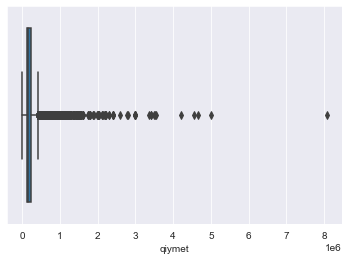

In [27]:
sns.boxplot(data.qiymet)

# Exploratory Data Analysis

In [28]:
features = ['mertebe', 'otaq_say', 'sahe', 'qiymet', 'mertebe_bina']

In [29]:
temp_data = data[features]

In [30]:
temp_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24331 entries, 2969337 to 2925897
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mertebe       24331 non-null  int32  
 1   otaq_say      24331 non-null  int32  
 2   sahe          24331 non-null  float64
 3   qiymet        24331 non-null  int32  
 4   mertebe_bina  24331 non-null  int32  
dtypes: float64(1), int32(4)
memory usage: 1.2+ MB


In [31]:
temp_data.describe().T

,count,mean,std,min,25%,50%,75%,max
mertebe,24331.000,7.956,4.984,1.000,4.000,7.000,12.000,27.000
otaq_say,24331.000,2.841,0.983,1.000,2.000,3.000,3.000,19.000
sahe,24331.000,107.646,63.151,15.000,69.000,95.000,131.000,1500.000
qiymet,24331.000,200405.405,192183.711,500.000,110000.000,155000.000,235000.000,8075000.000
mertebe_bina,24331.000,13.735,5.492,1.000,9.000,16.000,17.000,33.000


In [32]:
temp_data.shape

(24331, 5)

C:\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWar

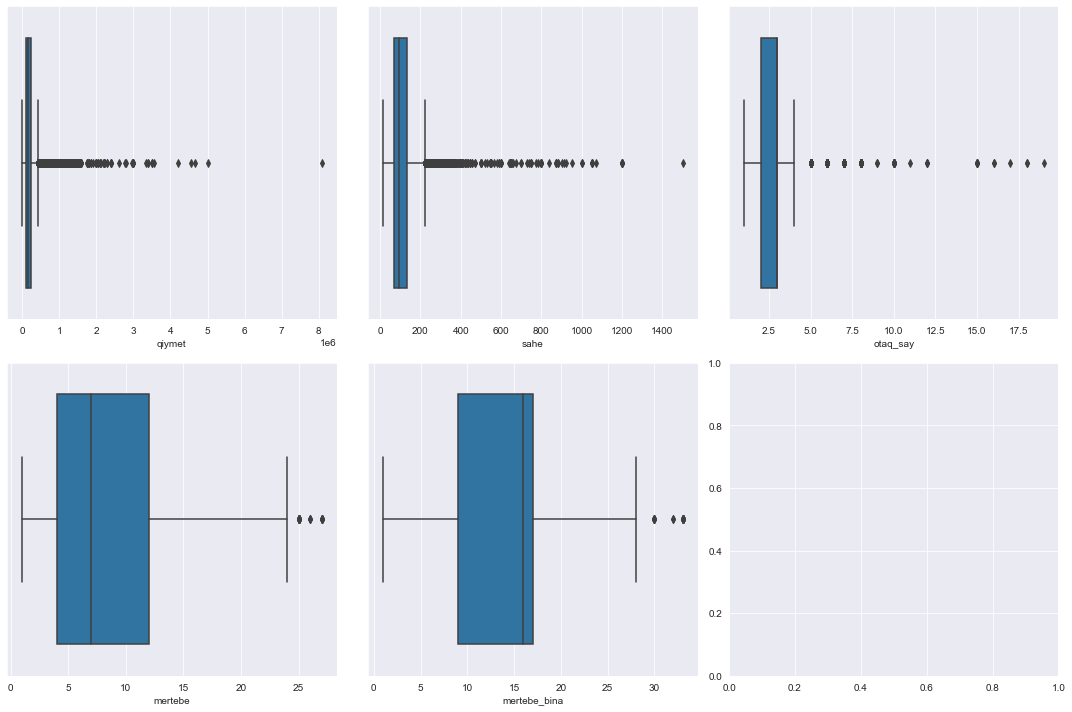

In [33]:
# Outlier Analysis
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
plt1 = sns.boxplot(temp_data['qiymet'], ax=axs[0, 0])
plt2 = sns.boxplot(temp_data['sahe'], ax=axs[0, 1])
plt3 = sns.boxplot(temp_data['otaq_say'], ax=axs[0, 2])
plt1 = sns.boxplot(temp_data['mertebe'], ax=axs[1, 0])
plt2 = sns.boxplot(temp_data['mertebe_bina'], ax=axs[1, 1])

plt.tight_layout()

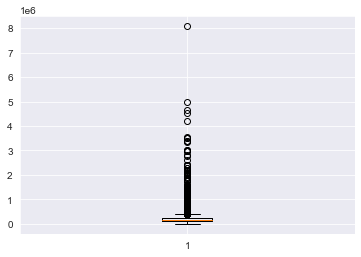

In [34]:
plt.boxplot(temp_data.qiymet)
low_threshold = temp_data.qiymet.quantile(0.0001)
high_threshold = temp_data.qiymet.quantile(0.99)
temp_data = temp_data[(temp_data.qiymet >= low_threshold) & (temp_data.qiymet <= high_threshold)]

In [35]:
temp_data.sahe.describe()

count   24086.000
mean      104.721
std        50.296
min        15.000
25%        68.000
50%        95.000
75%       130.000
max      1000.000
Name: sahe, dtype: float64

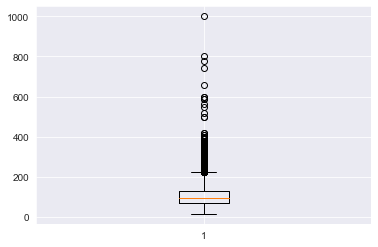

In [36]:
plt.boxplot(temp_data.sahe)
low_threshold = temp_data.sahe.quantile(0.001)
high_threshold = temp_data.sahe.quantile(0.99)
temp_data = temp_data[(temp_data.sahe >= low_threshold) & (temp_data.sahe <= high_threshold)]

In [37]:
temp_data.columns

Index(['mertebe', 'otaq_say', 'sahe', 'qiymet', 'mertebe_bina'], dtype='object')

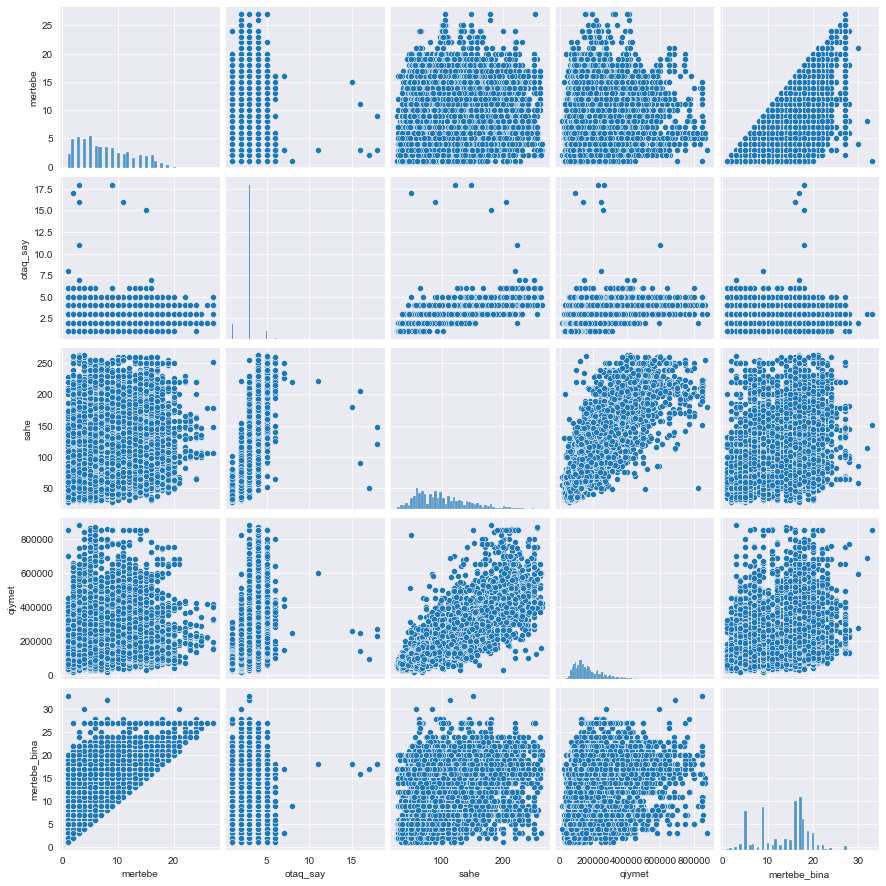

In [38]:
sns.pairplot(temp_data)
plt.show()

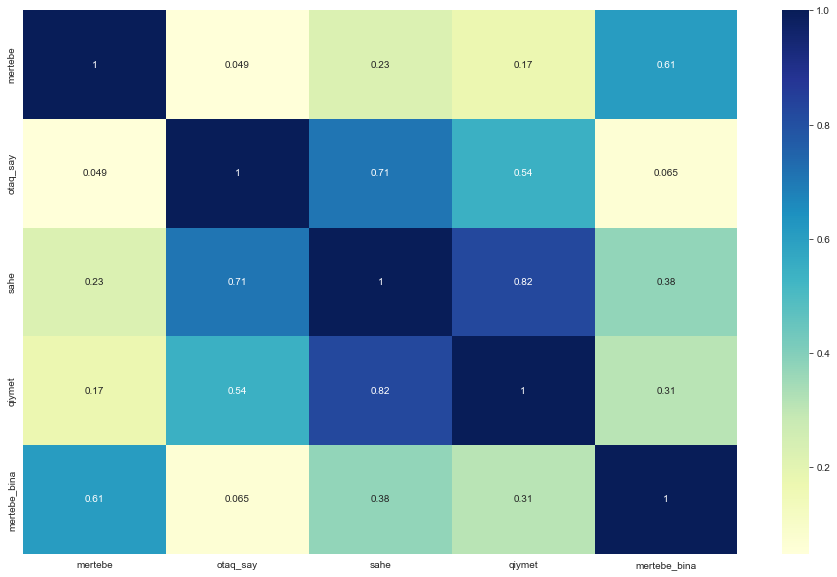

In [39]:
plt.figure(figsize=(16, 10))
sns.heatmap(temp_data.corr(), annot=True, cmap="YlGnBu")
plt.show()

In [40]:
data = temp_data.merge(data.drop(features, axis=1), on='elan_id')

In [41]:
data

,mertebe,otaq_say,sahe,qiymet,mertebe_bina,baxis_say,kupca,ipoteka,tecili,kateqoriya_Yeni tikili,...,mertebe_bina_mertebe_bina,mertebe_bina_tecili,mertebe_bina_kateqoriya_Yeni tikili,mertebe_bina_adres_avg,tecili_tecili,tecili_kateqoriya_Yeni tikili,tecili_adres_avg,kateqoriya_Yeni tikili_kateqoriya_Yeni tikili,kateqoriya_Yeni tikili_adres_avg,adres_avg_adres_avg
elan_id,,,,,,,,,,,,,,,,,,,,,
2969337,2,5,110.000,248000,7,91,1,0,1,1,...,49.000,7.000,7.000,1834437.905,1.000,1.000,262062.558,1.000,262062.558,68676784259.332
2801416,13,4,141.000,280000,19,296,1,0,1,1,...,361.000,19.000,19.000,3339583.180,1.000,1.000,175767.536,1.000,175767.536,30894226629.783
2903445,3,2,58.000,86000,5,1030,1,0,1,0,...,25.000,5.000,0.000,652049.878,1.000,0.000,130409.976,0.000,0.000,17006761721.251
2969332,9,3,194.000,475000,15,79,1,0,0,1,...,225.000,0.000,15.000,3930938.369,0.000,0.000,0.000,1.000,262062.558,68676784259.332
2969329,1,1,35.000,58500,5,436,1,0,0,0,...,25.000,0.000,0.000,623343.425,0.000,0.000,0.000,0.000,0.000,15542281029.446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2787423,12,2,76.000,130000,17,268,1,0,0,1,...,289.000,0.000,17.000,6492024.613,0.000,0.000,0.000,1.000,381883.801,145835237299.133
2877382,6,2,62.000,150000,8,212,0,0,0,1,...,64.000,0.000,8.000,2253253.726,0.000,0.000,0.000,1.000,281656.716,79330505511.371
2956992,3,3,150.000,269900,18,396,1,0,0,1,...,324.000,0.000,18.000,5069820.883,0.000,0.000,0.000,1.000,281656.716,79330505511.371


In [42]:
y = data[target]
X = data.drop([target], axis=1)
X

,mertebe,otaq_say,sahe,mertebe_bina,baxis_say,kupca,ipoteka,tecili,kateqoriya_Yeni tikili,adres_avg,...,mertebe_bina_mertebe_bina,mertebe_bina_tecili,mertebe_bina_kateqoriya_Yeni tikili,mertebe_bina_adres_avg,tecili_tecili,tecili_kateqoriya_Yeni tikili,tecili_adres_avg,kateqoriya_Yeni tikili_kateqoriya_Yeni tikili,kateqoriya_Yeni tikili_adres_avg,adres_avg_adres_avg
elan_id,,,,,,,,,,,,,,,,,,,,,
2969337,2,5,110.000,7,91,1,0,1,1,262062.558,...,49.000,7.000,7.000,1834437.905,1.000,1.000,262062.558,1.000,262062.558,68676784259.332
2801416,13,4,141.000,19,296,1,0,1,1,175767.536,...,361.000,19.000,19.000,3339583.180,1.000,1.000,175767.536,1.000,175767.536,30894226629.783
2903445,3,2,58.000,5,1030,1,0,1,0,130409.976,...,25.000,5.000,0.000,652049.878,1.000,0.000,130409.976,0.000,0.000,17006761721.251
2969332,9,3,194.000,15,79,1,0,0,1,262062.558,...,225.000,0.000,15.000,3930938.369,0.000,0.000,0.000,1.000,262062.558,68676784259.332
2969329,1,1,35.000,5,436,1,0,0,0,124668.685,...,25.000,0.000,0.000,623343.425,0.000,0.000,0.000,0.000,0.000,15542281029.446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2787423,12,2,76.000,17,268,1,0,0,1,381883.801,...,289.000,0.000,17.000,6492024.613,0.000,0.000,0.000,1.000,381883.801,145835237299.133
2877382,6,2,62.000,8,212,0,0,0,1,281656.716,...,64.000,0.000,8.000,2253253.726,0.000,0.000,0.000,1.000,281656.716,79330505511.371
2956992,3,3,150.000,18,396,1,0,0,1,281656.716,...,324.000,0.000,18.000,5069820.883,0.000,0.000,0.000,1.000,281656.716,79330505511.371


In [43]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_scaled = pd.DataFrame(data=X_scaled, columns=X.columns)

In [44]:
X_scaled

,mertebe,otaq_say,sahe,mertebe_bina,baxis_say,kupca,ipoteka,tecili,kateqoriya_Yeni tikili,adres_avg,...,mertebe_bina_mertebe_bina,mertebe_bina_tecili,mertebe_bina_kateqoriya_Yeni tikili,mertebe_bina_adres_avg,tecili_tecili,tecili_kateqoriya_Yeni tikili,tecili_adres_avg,kateqoriya_Yeni tikili_kateqoriya_Yeni tikili,kateqoriya_Yeni tikili_adres_avg,adres_avg_adres_avg
0,-1.192,2.531,0.169,-1.228,-0.457,0.522,-0.561,1.295,0.604,0.848,...,-1.175,0.268,-0.617,-0.590,1.295,1.691,1.844,0.604,1.046,0.715
1,1.026,1.386,0.872,0.970,-0.179,0.522,-0.561,1.295,0.604,-0.310,...,1.000,1.904,0.901,0.367,1.295,1.691,1.006,0.604,0.251,-0.430
2,-0.991,-0.904,-1.009,-1.594,0.816,0.522,-0.561,1.295,-1.656,-0.919,...,-1.342,-0.004,-1.503,-1.341,1.295,-0.591,0.565,-1.656,-1.368,-0.851
3,0.219,0.241,2.073,0.238,-0.473,0.522,-0.561,-0.772,0.604,0.848,...,0.052,-0.686,0.395,0.743,-0.772,-0.591,-0.701,0.604,1.046,0.715
4,-1.394,-2.050,-1.530,-1.594,0.011,0.522,-0.561,-0.772,-1.656,-0.996,...,-1.342,-0.686,-1.503,-1.359,-0.772,-0.591,-0.701,-1.656,-1.368,-0.896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23816,0.825,-0.904,-0.601,0.604,-0.217,0.522,-0.561,-0.772,0.604,2.457,...,0.498,-0.686,0.648,2.371,-0.772,-0.591,-0.701,0.604,2.150,3.054
23817,-0.386,-0.904,-0.918,-1.045,-0.293,-1.916,-0.561,-0.772,0.604,1.111,...,-1.070,-0.686,-0.491,-0.323,-0.772,-0.591,-0.701,0.604,1.227,1.038
23818,-0.991,0.241,1.076,0.787,-0.043,0.522,-0.561,-0.772,0.604,1.111,...,0.742,-0.686,0.775,1.467,-0.772,-0.591,-0.701,0.604,1.227,1.038
23819,0.219,1.386,0.396,-0.861,0.054,0.522,-0.561,-0.772,-1.656,-0.776,...,-0.952,-0.686,-1.503,-0.949,-0.772,-0.591,-0.701,-1.656,-1.368,-0.764


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)
X_train.shape, X_test.shape

((16674, 65), (7147, 65))

In [46]:
X_scaled

,mertebe,otaq_say,sahe,mertebe_bina,baxis_say,kupca,ipoteka,tecili,kateqoriya_Yeni tikili,adres_avg,...,mertebe_bina_mertebe_bina,mertebe_bina_tecili,mertebe_bina_kateqoriya_Yeni tikili,mertebe_bina_adres_avg,tecili_tecili,tecili_kateqoriya_Yeni tikili,tecili_adres_avg,kateqoriya_Yeni tikili_kateqoriya_Yeni tikili,kateqoriya_Yeni tikili_adres_avg,adres_avg_adres_avg
0,-1.192,2.531,0.169,-1.228,-0.457,0.522,-0.561,1.295,0.604,0.848,...,-1.175,0.268,-0.617,-0.590,1.295,1.691,1.844,0.604,1.046,0.715
1,1.026,1.386,0.872,0.970,-0.179,0.522,-0.561,1.295,0.604,-0.310,...,1.000,1.904,0.901,0.367,1.295,1.691,1.006,0.604,0.251,-0.430
2,-0.991,-0.904,-1.009,-1.594,0.816,0.522,-0.561,1.295,-1.656,-0.919,...,-1.342,-0.004,-1.503,-1.341,1.295,-0.591,0.565,-1.656,-1.368,-0.851
3,0.219,0.241,2.073,0.238,-0.473,0.522,-0.561,-0.772,0.604,0.848,...,0.052,-0.686,0.395,0.743,-0.772,-0.591,-0.701,0.604,1.046,0.715
4,-1.394,-2.050,-1.530,-1.594,0.011,0.522,-0.561,-0.772,-1.656,-0.996,...,-1.342,-0.686,-1.503,-1.359,-0.772,-0.591,-0.701,-1.656,-1.368,-0.896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23816,0.825,-0.904,-0.601,0.604,-0.217,0.522,-0.561,-0.772,0.604,2.457,...,0.498,-0.686,0.648,2.371,-0.772,-0.591,-0.701,0.604,2.150,3.054
23817,-0.386,-0.904,-0.918,-1.045,-0.293,-1.916,-0.561,-0.772,0.604,1.111,...,-1.070,-0.686,-0.491,-0.323,-0.772,-0.591,-0.701,0.604,1.227,1.038
23818,-0.991,0.241,1.076,0.787,-0.043,0.522,-0.561,-0.772,0.604,1.111,...,0.742,-0.686,0.775,1.467,-0.772,-0.591,-0.701,0.604,1.227,1.038
23819,0.219,1.386,0.396,-0.861,0.054,0.522,-0.561,-0.772,-1.656,-0.776,...,-0.952,-0.686,-1.503,-0.949,-0.772,-0.591,-0.701,-1.656,-1.368,-0.764


In [47]:

alphas = np.linspace(0, 10, 10)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=100)

hyper_param = {'alpha': alphas}

lasso_reg = Lasso()

grid_lasso = GridSearchCV(estimator=lasso_reg,
                          param_grid=hyper_param,
                          scoring='r2',
                          cv=cv,
                          n_jobs=-1,
                          return_train_score=True
                          )

grid_lasso.fit(X_train, y_train)

C:\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.832e+12, tolerance: 1.990e+10
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=100),
             estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': array([ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
        5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ])},
             return_train_score=True, scoring='r2')

In [48]:
grid_lasso.best_params_

{'alpha': 10.0}

In [49]:

from sklearn.linear_model import Ridge

model_params = {
    'tree': {
        'model': DecisionTreeRegressor(),
        'params': {
            "max_depth": [None, 1, 3, 5, 7, 9, 11, 12],
        }
    },
    'ridge_regression': {
        'model': Ridge(),
        'params': {
            'alpha': np.arange(0, 1, 0.01)
        }
    }
}

In [50]:
l_reg = LinearRegression()
l_reg.fit(X_train, y_train)
l_reg.score(X_test,y_test)

0.7772723453630558

In [51]:
scores = []

for model_name, mp in model_params.items():
    grids = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False, n_jobs=-1)
    grids.fit(X_train, y_train)
    scores.append({
        'model': grids,
        'model_name': model_name,
        'best_score': grids.best_score_,
        'best_params': grids.best_params_
    })



In [52]:
scores.append({
    'model': l_reg,
    'model_name': 'linear_regression',
    'best_score': l_reg.score(X_test, y_test),
    'best_params': 'default'
})
scores.append({
    'model': grid_lasso,
    'model_name': 'lasso_regression',
    'best_score': grid_lasso.best_score_,
    'best_params': grid_lasso.best_params_
})

rand_forest = RandomForestRegressor()
rand_forest.fit(X_train,y_train)
scores.append({
    'model' : rand_forest,
    'model_name' : 'random_forest',
    'best_score' : rand_forest.score(X_test,y_test),
    'best_params' : 'default'
})

In [53]:
for model_score in scores:
    curr_model = model_score['model']
    model_score['mean_abserr_train'] = met.mean_absolute_error(y_train, curr_model.predict(X_train))
    model_score['median_abserr_train'] = met.median_absolute_error(y_train, curr_model.predict(X_train))

    model_score['mean_abserr_test'] = met.mean_absolute_error(y_test, curr_model.predict(X_test))
    model_score['median_abserr_test'] = met.median_absolute_error(y_test, curr_model.predict(X_test))


In [54]:
model_scores = pd.DataFrame(scores, columns=['model_name', 'best_score', 'best_params','mean_abserr_train','median_abserr_train','mean_abserr_test','median_abserr_test'])
model_scores

,model_name,best_score,best_params,mean_abserr_train,median_abserr_train,mean_abserr_test,median_abserr_test
0,tree,0.776,{'max_depth': 7},28475.587,17589.903,31052.262,18011.571
1,ridge_regression,0.788,{'alpha': 0.99},30658.627,18493.447,31047.326,18976.256
2,linear_regression,0.777,default,30714.847,18599.330,31083.236,19266.744
3,lasso_regression,0.787,{'alpha': 10.0},30635.301,18429.277,31001.352,18976.022
4,random_forest,0.827,default,9327.169,4985.500,25252.462,13828.000
